In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ast
from datetime import datetime
from collections import Counter
from http.client import responses
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pygsheets
import re
import requests
from tqdm import tqdm


pd.set_option('display.max_colwidth', -1)

In [2]:
url_root_sheet = "https://docs.google.com/spreadsheets/d/1IyfSPiiR0DUxYuConiYzuokM2hUQbOBpuJAeAlGi7kc/edit#gid=223389382"
url_root_sheet = re.sub(r"/edit(.*)", '', url_root_sheet)

In [3]:
with open("data/data.json", "r") as f:
    processed = json.load(f)

df_root = pd.read_csv(processed[url_root_sheet] + "/root.csv", sep=";")
df_root

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,ErrorName,Text,Path,MeanMark,MeanPositiveMark,MeanMeanMark,Excellent,Good,Satisfactory,Fail
0,1,Бакалавриат,Программная инженерия,1,"1,2,3,4",Математический анализ,Федотов,https://drive.google.com/drive/folders/1n-ykGVz7eHWG_PgG0RSo-tBcGs_9s3xS?usp=sharing,3,Drive Directory,...,NaN,https://drive.google.com/drive/folders/1n-ykGVz7eHWG_PgG0RSo-tBcGs_9s3xS?usp=sharing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=0&fvid=982303739 https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=1790524453,"data/2023-04-10_15:58:57/statements/БПИ_1курс_2,3модуль_Компьютерный_практикум_по_матанализу_на_Python_Шайхелисламов.csv",5.56493,7.635431,5.729472,2677.0,661.0,263.0,1595.0
2,3,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=0&fvid=982303739 https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=1790524453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по математическому анализу в среде Matlab,Макаров С.Л.,http://serjmak.com/2students/matlaba/,5,NaN,...,NaN,http://serjmak.com/2students/matlaba/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Бакалавриат,Программная инженерия,1,"1,2,3,4",Алгебра,Чернышев Всеволод Леонидович,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A,6,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A/edit#gid=553615486,"data/2023-04-10_15:58:57/statements/БПИ_1курс_1,2,3,4модуль_Алгебра_Чернышев.csv",7.03770,7.177571,7.037700,474.0,262.0,148.0,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,343,Бакалавриат,Компьютерные науки и анализ данных,1,3,Программирование на С++,Леванов Дмитрий Александрович,https://docs.google.com/spreadsheets/d/1DC7xSS-2ycn-y3cSsegnFpms-wChg3dXMb4DGgE4ZZo,267,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1DC7xSS-2ycn-y3cSsegnFpms-wChg3dXMb4DGgE4ZZo/edit#gid=276600795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
343,344,Бакалавриат,Компьютерные науки и анализ данных,1,4,Инструменты промышленной разработки,Горшков Сергей Сергеевич,NaN,268,NaN,...,URL invalid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
344,345,Бакалавриат,Компьютерные науки и анализ данных,1,3-4,Правовая грамотность,Хабибулин Тагир Маратович,NaN,269,NaN,...,URL invalid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,346,Бакалавриат,Компьютерные науки и анализ данных,1,1-4,АЯ для ОиК целей,"Журавлева Анна Петровна, Сафонова Юлия Владимировна",NaN,270,NaN,...,URL invalid,SmartLMS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Анализ качества парсинга

In [ ]:
# Недоступные ссылки (либо отказ в доступе, либо ведомость удалена, либо еще что-то)
# Wrong format = гугл таблица сохранена в формате XLSX
df_root[pd.notna(df_root.ErrorName)]

In [ ]:
# Какие ошибки были при парсинге ссылок
# Wrong format = гугл таблица сохранена в формате XLSX
df_root.ErrorName.unique()

In [ ]:
# Какие ведомости были удалены
df_root[df_root.ErrorName == "Gone"]

In [ ]:
print("Валидных открытых ведомостей всего {} из {}".format(len(df_root[pd.isna(df_root.ErrorName)]), len(df_root)))

In [ ]:
print("Форматы ведостей")
print(df_root.Type.unique())

In [ ]:
# Ведомости, которые не были предоставлены
df_root[pd.isna(df_root.URL)]

In [ ]:
# Ведомости, у которых НЕ определен формат и валидна (и доступна) ссылка на ведомость
df_root[(pd.isna(df_root.Type)) & (pd.notna(df_root.URL))]

In [5]:
with open("config/config.json", "r") as f:
    config = json.load(f)

for url_type in config["URL_TYPE"].values():
    cnt_type = len(df_root[df_root.Type == url_type])
    cnt_type_url = len(df_root[(df_root.Type == url_type) & (pd.isna(df_root.ErrorName))])
    print("{}: valid and accessible {} out of {}".format(url_type, cnt_type_url, cnt_type))
    
cnt_unknown_url = len(df_root[(pd.isna(df_root.Type)) & (pd.notna(df_root.URL))])
cnt_unknown = len(df_root[pd.isna(df_root.Type)])
print("\nValid and accessible of unknown type:", cnt_unknown_url, "out of", cnt_unknown)

Google Sheet: valid and accessible 218 out of 236
Drive Directory: valid and accessible 5 out of 5
Drive PDF: valid and accessible 13 out of 13
Drive Unknown File: valid and accessible 0 out of 0
Sharepoint: valid and accessible 4 out of 6
MS Teams: valid and accessible 0 out of 0
Dropbox: valid and accessible 10 out of 10

Valid and accessible of unknown type: 26 out of 77


In [6]:
import math

print("Среди всех ведомостей\n")
for url_type in config["URL_TYPE"].values():
    cnt = len(df_root[df_root.Type == url_type])
    print("{} ~ {} %".format(url_type, math.ceil(100 * cnt / len(df_root))))

cnt = len(df_root[pd.isna(df_root.Type)])
print("\nOther types ~", math.ceil(100 * cnt / len(df_root)), "%")

Среди всех ведомостей

Google Sheet ~ 69 %
Drive Directory ~ 2 %
Drive PDF ~ 4 %
Drive Unknown File ~ 0 %
Sharepoint ~ 2 %
MS Teams ~ 0 %
Dropbox ~ 3 %

Other types ~ 23 %


In [7]:
print("Среди доступных ведомостей\n")
for url_type in config["URL_TYPE"].values():
    cnt = len(df_root[(df_root.Type == url_type) & (pd.isna(df_root.ErrorName))])
    print("{} ~ {} %".format(url_type, math.ceil(100 * cnt / len(df_root[pd.isna(df_root.ErrorName)]))))

cnt = len(df_root[pd.isna(df_root.Type) & (pd.isna(df_root.ErrorName))])
print("\nOther types ~", math.ceil(100 * cnt / len(df_root[pd.isna(df_root.ErrorName)])), "%")

Среди доступных ведомостей

Google Sheet ~ 79 %
Drive Directory ~ 2 %
Drive PDF ~ 5 %
Drive Unknown File ~ 0 %
Sharepoint ~ 2 %
MS Teams ~ 0 %
Dropbox ~ 4 %

Other types ~ 10 %


In [8]:
for error in df_root.ErrorName.unique():
    if pd.notna(error):
        cnt = len(df_root[df_root.ErrorName == error])
        print("{}: {}".format(error, cnt))

Wrong format: 1
Gone: 11
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/11h1SLHq7YJ2FHG9qJKMtrJ3QBUzmJadP_lzqfZi-2To?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
URL invalid: 51
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/1gJHOnOEUDECMxMwcizpdZVBrg_nXfOiLomshBmqLsDs?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
Not Found: 2
<HttpError 403 when requesting https://sheets.googleapis.com/v4/spreadsheets/1dJxb-yFrSq0UPVIFrm27c9jL9XT-wTkNlnkcLEn-obg?includeGridData=false&fields=%2A&alt=json returned "The caller does not have permission". Details: "The caller does not have permission">: 1
Unauthorized: 3


# Анализ стат. информации по ведомостям

In [9]:
tmp = df_root.groupby(by=["Level", "Program", "Year", "Module", "Discipline", "Teacher"]).sum()
tmp[tmp.MeanMark > 0][["Excellent", "Good", "Satisfactory", "Fail"]]

Excellent  \
Level       Program               Year Module  Discipline                                                                       Teacher                                   
Бакалавриат Программная инженерия 1    1,2,3   Научно-исследовательский семинар "Дистрибьюция программного обеспечения в Linux" Силаков Д.В.                  105.0       
                                               Программирование на C#                                                           Дударев В.А.                  344.0       
                                       1,2,3,4 Алгебра                                                                          Чернышев Всеволод Леонидович  474.0       
                                               Дискретная математика                                                            Дашков Евгений Владимирович   9290.0      
                                       2,3     Компьютерный практикум по матанализу на Python                                   Шайхелисламов Д.С.            2677.0      
                                       3,4     Экономика blended                                                                Шевченко Е.С.                 824.0       
                                  2    1,2     Алгоритмы и структуры данных                                                     Чернов Алексей Владимирович   10147.0     

                                                                                                                                                                Good  \
Level       Program               Year Module  Discipline                                                                       Teacher                                
Бакалавриат Программная инженерия 1    1,2,3   Научно-исследовательский семинар "Дистрибьюция программного обеспечения в Linux" Силаков Д.В.                  2.0      
                                               Программирование на C#                                                           Дударев В.А.                  41.0     
                                       1,2,3,4 Алгебра                                                                          Чернышев Всеволод Леонидович  262.0    
                                               Дискретная математика                                                            Дашков Евгений Владимирович   176.0    
                                       2,3     Компьютерный практикум по матанализу на Python                                   Шайхелисламов Д.С.            661.0    
                                       3,4     Экономика blended                                                                Шевченко Е.С.                 169.0    
                                  2    1,2     Алгоритмы и структуры данных                                                     Чернов Алексей Владимирович   1714.0   

                                                                                                                                                              Satisfactory  \
Level       Program               Year Module  Discipline                                                                       Teacher                                      
Бакалавриат Программная инженерия 1    1,2,3   Научно-исследовательский семинар "Дистрибьюция программного обеспечения в Linux" Силаков Д.В.                  5.0            
                                               Программирование на C#                                                           Дударев В.А.                  35.0           
                                       1,2,3,4 Алгебра                                                                          Чернышев Всеволод Леонидович  148.0          
                                               Дискретная математика                                                            Дашков Евгений Владимирович   335.0          
                                       2,3     Компьютерный п

In [10]:
len(tmp)

267

In [11]:
len(df_root)

347

In [12]:
df_root[df_root.IsParsed == True]

,ID,Level,Program,Year,Module,Discipline,Teacher,URL,Row,Type,...,ErrorName,Text,Path,MeanMark,MeanPositiveMark,MeanMeanMark,Excellent,Good,Satisfactory,Fail
1,2,Бакалавриат,Программная инженерия,1,"2,3",Компьютерный практикум по матанализу на Python,Шайхелисламов Д.С.,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k,4,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=0&fvid=982303739 https://docs.google.com/spreadsheets/d/1QwLYiokR_V_eYYzpKkOedOQaPY4A07HyzrqjGJgAQ6k/edit#gid=1790524453,"data/2023-04-10_15:58:57/statements/БПИ_1курс_2,3модуль_Компьютерный_практикум_по_матанализу_на_Python_Шайхелисламов.csv",5.564930,7.635431,5.729472,2677.0,661.0,263.0,1595.0
4,5,Бакалавриат,Программная инженерия,1,"1,2,3,4",Алгебра,Чернышев Всеволод Леонидович,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A,6,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1fZEpApQu46aBq_1OO9C03ttjyLWhS_MH_G3SGKvf12A/edit#gid=553615486,"data/2023-04-10_15:58:57/statements/БПИ_1курс_1,2,3,4модуль_Алгебра_Чернышев.csv",7.037700,7.177571,7.037700,474.0,262.0,148.0,91.0
8,9,Бакалавриат,Программная инженерия,1,"1,2,3",Программирование на C#,Дударев В.А.,https://docs.google.com/spreadsheets/d/1-QFsZNikCjVGx7rwRFq1FncGM5c-lUpukEmLv009NlI,9,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1-QFsZNikCjVGx7rwRFq1FncGM5c-lUpukEmLv009NlI/edit#gid=1150291018 (1 модуль) https://drive.google.com/drive/folders/1-wn4IV22GNIekW7_nhl_wBzHVdr6trYJ?usp=sharing (итоговая) https://edu.hse.ru/grade/report/grader/index.php?id=105244,"data/2023-04-10_15:58:57/statements/БПИ_1курс_1,2,3модуль_Программирование_на_C#_Дударев.csv",6.943806,7.646976,5.621111,344.0,41.0,35.0,102.0
12,13,Бакалавриат,Программная инженерия,1,"1,2,3,4",Дискретная математика,Дашков Евгений Владимирович,https://docs.google.com/spreadsheets/d/1_Et9QKj-o7Jtsju8PZi6GA-v81JYA-pA8HGwasBUQq8,11,Google Sheet,...,NaN,https://docs.google.com/spreadsheets/d/1_Et9QKj-o7Jtsju8PZi6GA-v81JYA-pA8HGwasBUQq8/edit#gid=0,"data/2023-04-10_15:58:57/statements/БПИ_1курс_1,2,3,4модуль_Дискретная_математика_Дашков.csv",7.217840,9.569801,7.184429,9290.0,176.0,335.0,3435.0
15,16,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/19LqlpP86hnl5g6kYVb-EW_zMJunfJkYNu80vHMW47Jc,13,Google Sheet,...,NaN,"218 https://docs.google.com/spreadsheets/d/1nHYRfFInocrA1Fx80hMEdiNeJC31KQ8wdbl5ycXgw20/edit?usp=sharing 219 https://docs.google.com/spreadsheets/d/19LqlpP86hnl5g6kYVb-EW_zMJunfJkYNu80vHMW47Jc/edit?usp=sharing 2110 https://docs.google.com/spreadsheets/d/1YiaRIOYvM_B-X0G3oS3ITP2kNxEDk8UmFyF_w07xJ9U/edit?usp=sharing 211 https://docs.google.com/spreadsheets/d/1Ib9OTHr9klpR1jS0_-eSncCLTvDB6G9f4kQEAyNrWtU/edit 212 https://docs.google.com/spreadsheets/d/1rbrD3QoCHVWue-t1JaQoKBYh3eeKB_Kw/edit#gid=194954283 213 https://docs.google.com/spreadsheets/d/14WOr06eZUHK4YsUZgRG-MdW3b_sf9nMl/edit?rtpof=true&sd=true#gid=1853218252 214,15,16 https://drive.google.com/drive/folders/1TxJ2jY3WyfrF96wfFKLGUPmYDGmQ1N4M?usp=sharing 217 https://docs.google.com/spreadsheets/d/11h1SLHq7YJ2FHG9qJKMtrJ3QBUzmJadP_lzqfZi-2To/edit#gid=839988809 2111 https://docs.google.com/spreadsheets/d/11I7czsxNIVUdXXQj7BTuXHEJG9KKaXXdf_UU0zRKr-w/edit#gid=1461988659","data/2023-04-10_15:58:57/statements/БПИ_1курс_3,4модуль_Экономика_blended_Шевченко.csv",7.652039,8.534967,7.564787,468.0,60.0,42.0,97.0
16,17,Бакалавриат,Программная инженерия,1,"3,4",Экономика blended,Шевченко Е.С.,https://docs.google.com/spreadsheets/d/1YiaRIOYvM_B-X0G3oS3ITP2kNxEDk8UmFyF_w07xJ9U,13,Google Sheet,...,NaN,"218 https://docs.google.com/spreadsheets/d/1nHYRfFInocrA1Fx80hMEdiNeJC31KQ8wdbl5ycXgw20/edit?usp=sharing 219 https://docs.google.com/spreadsheets/d/19LqlpP86hnl5g6kYVb-EW_zMJunfJkYNu80vHMW47Jc/edit?usp=sharing 2110 https://docs.google.com/spreadsheets/d/1YiaRIOYvM_B-X0G3oS3ITP2kNxEDk8UmFyF_w07xJ9

In [23]:
parsed_df = df_root[df_root.IsParsed == True]
path = parsed_df.iloc[1].Path
df_sheet = pd.read_csv(path, sep=";")
print(path)
df_sheet

data/2023-04-10_15:58:57/statements/БПИ_1курс_1,2,3,4модуль_Алгебра_Чернышев.csv


,ID,Student,Group,MarksDict,MarksNorm,Excellent,Good,Satisfactory,Fail,Mean
0,1,Абиев Марик Олегович,NaN,"{'КР (C)': 7.0, 'ИДЗ1 (D)': 9.0, 'ИДЗ2 (E)': 8.0, 'Семинары (F)': 10.0, 'ЭО (G)': 6.0}","[7.777777777777778, 9.0, 8.0, 10.0, 6.666666666666667]",4,1,0,0,8.288889
1,2,Александрова Анастасия Васильевна,NaN,"{'КР (C)': 3.0, 'ИДЗ1 (D)': 9.0, 'ИДЗ2 (E)': 9.0, 'Семинары (F)': 10.0, 'ЭО (G)': 6.0}","[3.3333333333333335, 9.0, 9.0, 10.0, 6.666666666666667]",3,1,0,1,7.600000
2,4,Безруков Михаил Александрович,NaN,"{'КР (C)': 9.0, 'ИДЗ1 (D)': 10.0, 'ИДЗ2 (E)': 9.0, 'Семинары (F)': 10.0, 'ЭО (G)': 6.0}","[10.0, 10.0, 9.0, 10.0, 6.666666666666667]",4,1,0,0,9.133333
3,5,Воробьев Артём Александрович,NaN,"{'КР (C)': 5.0, 'ИДЗ1 (D)': 6.0, 'ИДЗ2 (E)': 8.0, 'Семинары (F)': 7.0, 'ЭО (G)': 3.0}","[5.555555555555555, 6.0, 8.0, 7.0, 3.3333333333333335]",1,3,0,1,5.977778
4,6,Данилов Никита Александрович,NaN,"{'КР (C)': 2.0, 'ИДЗ1 (D)': 3.0, 'ИДЗ2 (E)': 6.0, 'Семинары (F)': 7.0, 'ЭО (G)': 4.0}","[2.2222222222222223, 3.0, 6.0, 7.0, 4.444444444444445]",0,2,1,2,4.533333
...,...,...,...,...,...,...,...,...,...,...
190,28,Фирсов Федор Александрович,NaN,"{'КР (C)': 7.0, 'ИДЗ1 (D)': 10.0, 'ИДЗ2 (E)': 7.0, 'Семинары (F)': 10.0, 'ЭО (G)': 5.0}","[8.75, 10.0, 7.0, 10.0, 5.555555555555555]",3,2,0,0,8.261111
191,29,Черкасский Виталий Александрович,NaN,"{'КР (C)': 5.0, 'ИДЗ1 (D)': 9.0, 'ИДЗ2 (E)': 0.0, 'Семинары (F)': 3.0, 'ЭО (G)': 3.0}","[6.25, 9.0, 0.0, 3.0, 3.3333333333333335]",1,1,0,3,4.316667
192,30,Шарапов Егор Сергеевич,NaN,"{'КР (C)': 5.0, 'ИДЗ1 (D)': 10.0, 'ИДЗ2 (E)': 10.0, 'Семинары (F)': 10.0, 'ЭО (G)': 5.0}","[6.25, 10.0, 10.0, 10.0, 5.555555555555555]",3,2,0,0,8.361111
193,31,Швецов Данил Игоревич,NaN,"{'КР (C)': 7.0, 'ИДЗ1 (D)': 10.0, 'ИДЗ2 (E)': 7.0, 'Семинары (F)': 10.0, 'ЭО (G)': 5.0}","[8.75, 10.0, 7.0, 10.0, 5.555555555555555]",3,2,0,0,8.261111


In [24]:
len(df_sheet.Student.unique())

195

<BarContainer object of 6 artists>

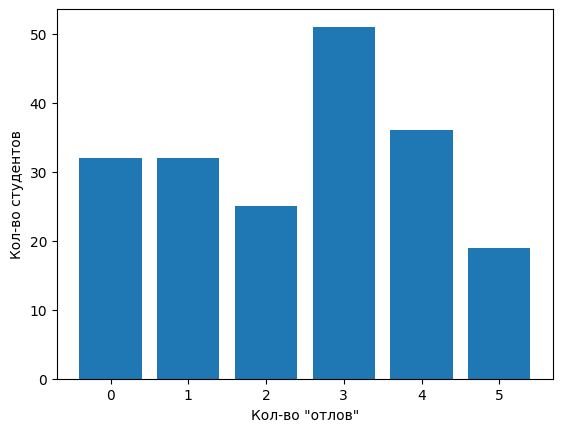

In [25]:
excellent = Counter(df_sheet.Excellent.to_list())
excellent_x, excellent_y = excellent.keys(), excellent.values()
plt.xlabel("Кол-во \"отлов\"")
plt.ylabel("Кол-во студентов")
plt.bar(excellent_x, excellent_y)

<BarContainer object of 6 artists>

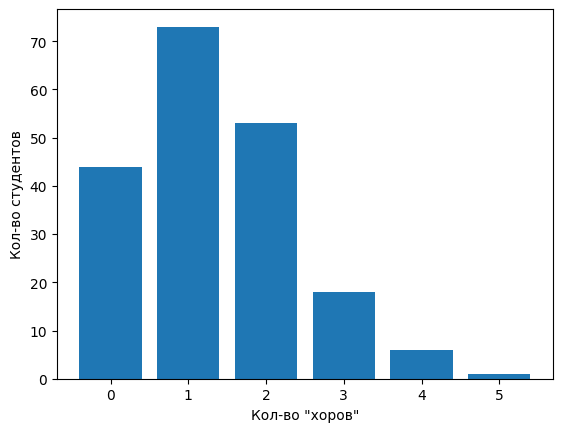

In [26]:
good = Counter(df_sheet.Good.to_list())
good_x, good_y = good.keys(), good.values()
plt.xlabel("Кол-во \"хоров\"")
plt.ylabel("Кол-во студентов")
plt.bar(good_x, good_y)

<BarContainer object of 5 artists>

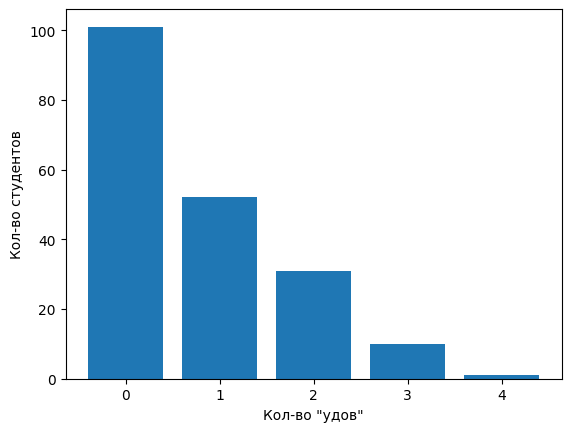

In [27]:
satisfactory = Counter(df_sheet.Satisfactory.to_list())
satisfactory_x, satisfactory_y = satisfactory.keys(), satisfactory.values()
plt.xlabel("Кол-во \"удов\"")
plt.ylabel("Кол-во студентов")
plt.bar(satisfactory_x, satisfactory_y)

<BarContainer object of 5 artists>

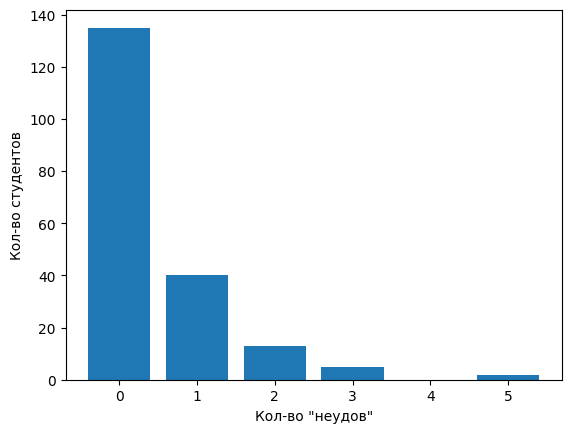

In [29]:
fail = Counter(df_sheet.Fail.to_list())
fail_x, fail_y = fail.keys(), fail.values()
plt.xlabel("Кол-во \"неудов\"")
plt.ylabel("Кол-во студентов")
plt.bar(fail_x, fail_y)

<BarContainer object of 4 artists>

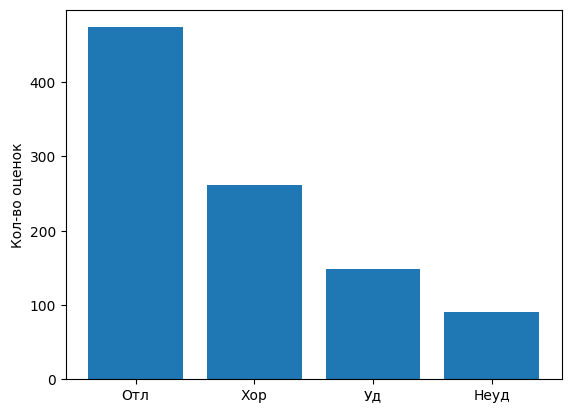

In [30]:
plt.ylabel("Кол-во оценок")
plt.bar(["Отл", "Хор", "Уд", "Неуд"], [df_sheet.Excellent.sum(), df_sheet.Good.sum(), df_sheet.Satisfactory.sum(), df_sheet.Fail.sum()])

In [35]:
df_students = pd.read_csv(processed[url_root_sheet] + "/students.csv", sep=";")
df_students[df_students.MarkSum > 0]

,ID,Name,Year,Group,Program,Email,IDCard,MarkSum,MarkCount,Mean,Excellent,Good,Satisfactory,Fail


## Вытаскиваем данные из csv

In [20]:
ast.literal_eval(df_sheet.MarksDict[0])

{' (K)': 1.0,
 ' (L)': 0.0,
 ' (M)': 1.0,
 ' (N)': 1.0,
 ' (O)': 1.0,
 ' (P)': 1.0,
 ' (Q)': 1.0,
 ' (T)': 1.0,
 'a (V)': 0.95,
 'b (W)': 0.95,
 'a (X)': 0.1,
 'b (Y)': 0.0,
 ' (Z)': 1.0,
 ' (AA)': 1.0,
 ' (AB)': 0.7,
 'a (AC)': 1.0,
 'b (AD)': 1.0,
 'c (AE)': 1.0,
 ' (AG)': 1.0,
 'a (AH)': 0.95,
 'b (AI)': 0.95,
 'a (AJ)': 1.0,
 'b (AK)': 1.0,
 'c (AL)': 0.5,
 'd (AM)': 0.9,
 ' (AN)': 1.0,
 ' (AS)': 1.0,
 ' (AU)': 0.1,
 ' (AV)': 1.0,
 ' (AW)': 1.0,
 ' (AX)': 1.0,
 ' (AY)': 1.0,
 ' (AZ)': 1.0,
 'a (BA)': 0,
 ' (BD)': 1.0,
 ' (BE)': 0.95,
 ' (BF)': 1.0,
 ' (BG)': 0.1,
 ' (BH)': 0.8,
 ' (BI)': 0,
 ' (BJ)': 0.5,
 ' (BK)': 0.95,
 ' (BL)': 0.1,
 ' (BO)': 1.0,
 ' (BQ)': 0.0,
 ' (BR)': 0.2,
 ' (BS)': 0,
 ' (BT)': 0.0,
 ' (BU)': 0.0,
 ' (BV)': 0.0,
 ' (BW)': 0,
 ' (BX)': 0.7,
 'a (BZ)': 1.0,
 'b (CA)': 1.0,
 ' (CB)': 0.5,
 ' (CC)': 1.0,
 ' (CD)': 1.0,
 ' (CE)': 1.0,
 ' (CF)': 1.0,
 ' (CG)': 0.1,
 ' (CH)': 0.8,
 ' (CI)': 1.0,
 ' (CJ)': 1.0,
 ' (CK)': 1.0,
 ' (CL)': 0.7,
 ' (CM)': 1.0,
 ' (CN)':

In [21]:
ast.literal_eval(df_sheet.MarksNorm[0])

[10.0,
 0.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.5,
 9.5,
 1.0,
 0.0,
 10.0,
 10.0,
 7.0,
 10.0,
 10.0,
 10.0,
 10.0,
 9.5,
 9.5,
 10.0,
 10.0,
 5.0,
 9.0,
 10.0,
 10.0,
 1.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 0.0,
 10.0,
 10.0,
 10.0,
 1.0,
 8.0,
 0.0,
 5.0,
 9.5,
 10.0,
 10.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 10.0,
 10.0,
 5.0,
 10.0,
 10.0,
 10.0,
 10.0,
 1.0,
 8.0,
 10.0,
 10.0,
 10.0,
 7.0,
 10.0,
 0.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 0.0,
 10.0,
 0.0,
 10.0,
 10.0,
 10.0,
 10.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.5,
 10.0,
 10.0,
 6.0,
 10.0,
 10.0,
 7.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 7.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 5.0,
 0.0,
 10.0,
 10.0,
 10.0,
 8.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 2.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0]